# 06. PyTorch Transfer Learning

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem

* Pretrained model = foundation models

In [7]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


Now we've got the versions of torch and torchvision


In [8]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

# 1. Get data

We need our pizza steak sushi data to build a transfer learning model on



In [10]:
import os
import zipfile
import requests

from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes

# If the image folader doesn't exist, downloade it and perpare it ...
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download.")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)
  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")


data/pizza_steak_sushi directory exists, skipping re-download.


In [11]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made.

There's one thing we have to think about when loading: how to **transform** it?

And with `torchvision 0.13+` there are two ways to do this:
1. Manually created transform - you define what transforms you want your data to go though.
2. Automatically created transforms - the transforms for your data are defined by the model you like to use

**Important point**: when using a pretrained model, it's important that the data(including your custom data) that you pass through it is **transformed** in the same way that the data themodel was trained on.

In [13]:
from going_modular.going_modular import data_setup


train_dataloader, test_dataloader, class_name = data_setup.create_dataloaders()

TypeError: create_dataloaders() missing 4 required positional arguments: 'train_dir', 'test_dir', 'transform', and 'batch_size'

### 2.1 Creating a transform for `torchvision.models`(manual creating)

In [14]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [15]:
from going_modular.going_modular import data_setup


train_dataloader, test_dataloader, class_name = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=manual_transforms,
                                                                              batch_size=32)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78ca3a2dba60>,
 <torch.utils.data.dataloader.DataLoader at 0x78ca3a2d9060>)

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As os `torchvision 0.13+` there is now support for automatic data transform creation based on the pretrained model weights you're using

In [16]:
import torchvision
torchvision.__version__

'0.16.0+cu121'

In [17]:
# Get a set of pretrained model weights
weight = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT": Best available weights
weight

EfficientNet_B0_Weights.IMAGENET1K_V1

In [20]:
# Get the transforms used to create our pertrained weights
auto_transforms = weight.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [22]:
# Create DataLoader using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=auto_transforms,
                                                                              batch_size=32)

In [23]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78ca3a0ae1d0>,
 ['pizza', 'steak', 'sushi'])

# 3. Getting a pretrained model

There aere various places to get a pretained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plently of different models)
4. Paperwithcode(for models across different problem spaces/domains)

### 3.1 Which pretained model should you use?
*Experiment, experiment, experiment!*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed - how fast does it run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem?

where does the model live?

Is it on device?

Or does it live on a server

### 3.2 Setting up a pretrained model

Wanna create an instance of pretrained EffNetB0


https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html


In [26]:
# OLD method of creating a pretrained model(prior to torchvision v0.13)
model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model(torchvision 0.13++)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 23.2MB/s]


RuntimeError: invalid hash value (expected "3dd342df", got "7f5810bc96def8f7552d5b7e68d53c4786f81167d28291b21c0d90e1fca14934")

In [71]:
# New method of creating a pretrained model(torchvision 0.13++)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model=efficientnet_b0(weights="DEFAULT").to(device)

In [72]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [73]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [ ]:
# Print out with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundation model and update the output layers to suit your own problem.




In [75]:
# Freeze all of the base layers in EffnetB0
for param in model.features.parameters():
  param.requires_grad = False

In [76]:
# Adjust the classifier head of our model to suit our problem
from torch import nn
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

#4. Traini model

In [78]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [79]:
# Import train function
from going_modular.going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=15,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.5f} second")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.5785 | train_acc: 0.8945 | test_loss: 0.5743 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.5263 | train_acc: 0.9102 | test_loss: 0.5470 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5226 | train_acc: 0.8008 | test_loss: 0.5291 | test_acc: 0.8665
Epoch: 9 | train_loss: 0.5671 | train_acc: 0.8125 | test_loss: 0.5076 | test_acc: 0.8456
Epoch: 10 | train_loss: 0.4847 | train_acc: 0.8203 | test_loss: 0.4400 | test_acc: 0.9062
Epoch: 11 | train_loss: 0.4309 | train_acc: 0.9297 | test_loss: 0.4623 | test_acc: 0.8759
Epoch: 12 | train_l

In [ ]:
results

# 5. Evaluate our model with loss curve

In [81]:
# Way 1:  write a plot_result function by hand

def plot_loss(results):
  """
  1. divided the results into a vector from a dict
  2. plot the curve with subplot
  """
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]
  train_acc = results["train_acc"]
  test_acc = results["test_acc"]
  epochs= range(len(train_loss))

  plt.figure(figsize=[12,8])
  plt.subplot(2, 1, 1)
  plt.plot(epochs, train_loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.xlabel("Epochs")
  plt.title("Loss Curve")
  plt.legend()

  plt.figure(figsize=[12,8])
  plt.subplot(2, 1, 2)
  plt.plot(epochs, train_acc, label="train_acc")
  plt.plot(epochs, test_acc, label="test_acc")
  plt.xlabel("Epochs")
  plt.title("acc Curve")
  plt.legend()




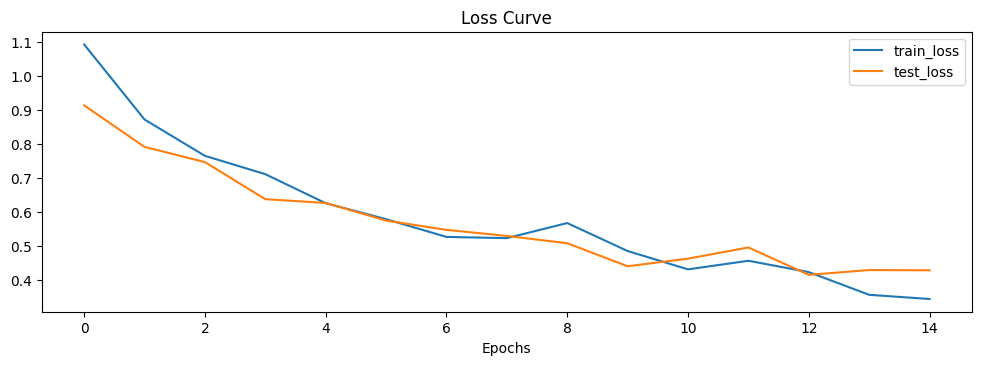

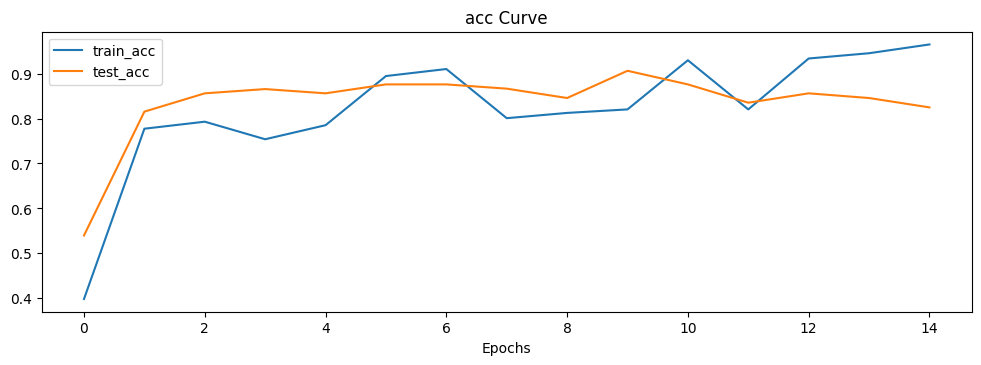

In [82]:
import matplotlib.pyplot as plt

plot_loss(results)

In [83]:
# Way 2: Downloading help function from GitHub
try:
  from helper_functions import plot_loss_curves
except:
  print("Downloading the helper_function ...")
  from pathlib import Path
  import requests

  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")

  path = Path("helper_functions.py")

  with open(path, "wb") as f:
    f.write(request.content)


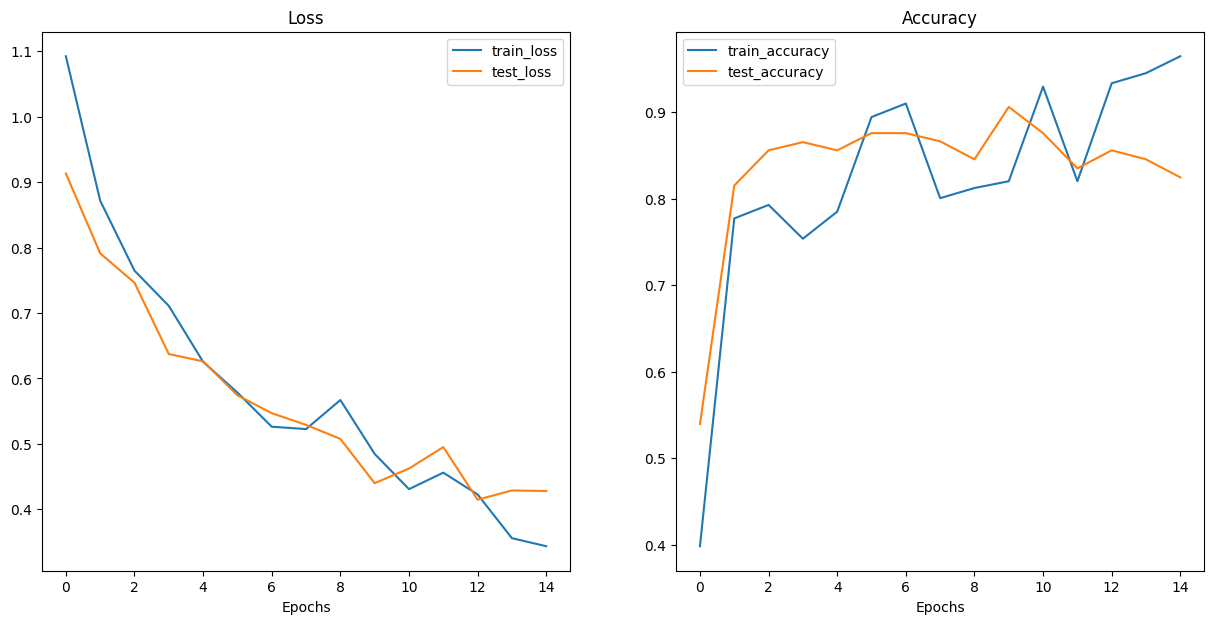

In [84]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)